In [1]:
# Find anamolous DNS queries
from ssh2.session import Session
import socket

class SSHCommand:
    address = ""
    username = ""
    password = ""
    
    def __init__(self, address="127.0.0.1", username="none", password="none"):
        self.address = address
        self.username = username
        self.password = password
    
    def execute(self, command = ""):
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.connect((self.address, 22))
        session = Session()
        session.handshake(sock)
        session.userauth_password(self.username, self.password)
        channel = session.open_session()
        channel.execute(command)
        result = ""
        size, result = channel.read()
        while size > 0:
            size, data = channel.read()
            result = result + data
        channel.close()
        session.disconnect()
        return result.decode('ascii')


In [2]:
ssh = SSHCommand(address='172.16.1.17', username='admin', password='password')
result = ssh.execute('echo -e \"timestamp\tuid\torig_host\torig_port\tresp_host\tresp_port\tproto\ttrans_id\tquery\tqclass\tqclass_name\tqtype\tqtype_name\trcode\trcode_name\tAA\tTC\tRD\tRA\tZ\tAnswers\" && zcat /nsm/zeek/logs/2021-09-08/dns* | jq -j \'select(.answers != null) | .ts, \"\t\", .uid, \"\t\", .[\"id.orig_h\"], \"\t\", .[\"id.orig_p\"], \"\t\", .[\"id.resp_h\"], \"\t\", .[\"id.resp_p\"], \"\t\", .proto, \"\t\", .trans_id, \"\t\", .query, \"\t\", .qclass, \"\t\", .qclass_name, \"\t\", .qtype, \"\t\", .qtype_name, \"\t\", .rcode, \"\t\", .rcode_name, \"\t\", .AA, \"\t\", .TC, \"\t\", .RD, \"\t\", .RA, \"\t\", .Z, \"\t\", ([(.answers | sort | join(\",\"))] |@csv), \"\n\"\'')

In [3]:
from io import StringIO
import pandas as pd

def string_to_df(data):
    return pd.read_csv(StringIO(data), sep="\t")

df = string_to_df(result)
#all_pkts = df['orig_pkts'] + df['resp_pkts']
#all_bytes = df['orig_bytes'] + df['resp_bytes']
#total_pkts = df.sum('all_pkts')
#print(total_pkts)
#df["all_pkts"] = all_pkts
#df["all_bytes"] = all_bytes
df

,timestamp,uid,orig_host,orig_port,resp_host,resp_port,proto,trans_id,query,qclass,...,qtype,qtype_name,rcode,rcode_name,AA,TC,RD,RA,Z,Answers
0,1.631113e+09,CY22WW3lOQrdbOrVg,172.16.1.10,25571,172.16.1.14,53,udp,27554,vcsa.deploy.local,1,...,1,A,0,NOERROR,True,False,True,True,0,172.16.1.10
1,1.631113e+09,CAXZRvqa055chpJA7,172.16.1.10,57029,172.16.1.14,53,udp,27140,vcsa.deploy.local,1,...,1,A,0,NOERROR,True,False,True,True,0,172.16.1.10
2,1.631113e+09,CENjs72eJbrTxhr7yj,172.16.1.10,16551,172.16.1.14,53,udp,46374,vcsa.deploy.local,1,...,1,A,0,NOERROR,True,False,True,True,0,172.16.1.10
3,1.631113e+09,C5u5sY0Vdd2WcMFZ3,172.16.1.10,34862,172.16.1.14,53,udp,38058,vcsa.deploy.local,1,...,1,A,0,NOERROR,True,False,True,True,0,172.16.1.10
4,1.631113e+09,C1QsD02Y8im0lfnDz8,172.16.1.10,25756,172.16.1.14,53,udp,48892,vcsa.deploy.local,1,...,1,A,0,NOERROR,True,False,True,True,0,172.16.1.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8348,1.631124e+09,Ca1UXq1vfweNhlnFLa,172.16.1.10,39473,172.16.1.14,53,udp,42261,vcsa.deploy.local,1,...,1,A,0,NOERROR,True,False,True,True,0,172.16.1.10
8349,1.631124e+09,CYuaJB4oYq68NLZmW9,172.16.1.10,38644,172.16.1.14,53,udp,23308,vcsa.deploy.local,1,...,1,A,0,NOERROR,True,False,True,True,0,172.16.1.10
8350,1.631124e+09,CU79Py1aNyn3w93cr3,172.16.1.10,42741,172.16.1.14,53,udp,57355,vcsa.deploy.local,1,...,1,A,0,NOERROR,True,False,True,True,0,172.16.1.10
8351,1.631124e+09,C5vAU04ppPL6l8LIUi,172.16.1.10,3682,172.16.1.14,53,udp,57582,vcsa.deploy.local,1,...,1,A,0,NOERROR,True,False,True,True,0,172.16.1.10


In [4]:
#df.drop([57145], inplace=True)
df.drop(columns=['timestamp', 'uid', 'orig_host', 'orig_port', 'resp_host', 'resp_port', 'proto'], inplace=True)
df

,trans_id,query,qclass,qclass_name,qtype,qtype_name,rcode,rcode_name,AA,TC,RD,RA,Z,Answers
0,27554,vcsa.deploy.local,1,C_INTERNET,1,A,0,NOERROR,True,False,True,True,0,172.16.1.10
1,27140,vcsa.deploy.local,1,C_INTERNET,1,A,0,NOERROR,True,False,True,True,0,172.16.1.10
2,46374,vcsa.deploy.local,1,C_INTERNET,1,A,0,NOERROR,True,False,True,True,0,172.16.1.10
3,38058,vcsa.deploy.local,1,C_INTERNET,1,A,0,NOERROR,True,False,True,True,0,172.16.1.10
4,48892,vcsa.deploy.local,1,C_INTERNET,1,A,0,NOERROR,True,False,True,True,0,172.16.1.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8348,42261,vcsa.deploy.local,1,C_INTERNET,1,A,0,NOERROR,True,False,True,True,0,172.16.1.10
8349,23308,vcsa.deploy.local,1,C_INTERNET,1,A,0,NOERROR,True,False,True,True,0,172.16.1.10
8350,57355,vcsa.deploy.local,1,C_INTERNET,1,A,0,NOERROR,True,False,True,True,0,172.16.1.10
8351,57582,vcsa.deploy.local,1,C_INTERNET,1,A,0,NOERROR,True,False,True,True,0,172.16.1.10


In [5]:
df.drop(columns=['qclass', 'qclass_name', 'qtype_name', 'rcode_name', 'AA', 'TC', 'RD', 'RA', 'Z', 'trans_id'], inplace=True)
df

,query,qtype,rcode,Answers
0,vcsa.deploy.local,1,0,172.16.1.10
1,vcsa.deploy.local,1,0,172.16.1.10
2,vcsa.deploy.local,1,0,172.16.1.10
3,vcsa.deploy.local,1,0,172.16.1.10
4,vcsa.deploy.local,1,0,172.16.1.10
...,...,...,...,...
8348,vcsa.deploy.local,1,0,172.16.1.10
8349,vcsa.deploy.local,1,0,172.16.1.10
8350,vcsa.deploy.local,1,0,172.16.1.10
8351,vcsa.deploy.local,1,0,172.16.1.10


In [6]:
def query_length(query):
    return len(query)

def query_parts(query):
    return len(query.split('.'))

def query_suffix_length(query):
    return len(query.split('.')[-1])

def query_domain_length(query):
    try:
        length =  len(query.split('.')[-2])
    except:
        length = 0
    return length

qlengths = [query_length(query) for query in df['query']]
qparts = [query_parts(query) for query in df['query']]
qsufflengths = [query_suffix_length(query) for query in df['query']]
qdomlengths = [query_domain_length(query) for query in df['query']]

df['qlength'] = qlengths
df['qparts'] = qparts
df['suffixlength'] = qsufflengths
df['domainlength'] = qdomlengths
df

,query,qtype,rcode,Answers,qlength,qparts,suffixlength,domainlength
0,vcsa.deploy.local,1,0,172.16.1.10,17,3,5,6
1,vcsa.deploy.local,1,0,172.16.1.10,17,3,5,6
2,vcsa.deploy.local,1,0,172.16.1.10,17,3,5,6
3,vcsa.deploy.local,1,0,172.16.1.10,17,3,5,6
4,vcsa.deploy.local,1,0,172.16.1.10,17,3,5,6
...,...,...,...,...,...,...,...,...
8348,vcsa.deploy.local,1,0,172.16.1.10,17,3,5,6
8349,vcsa.deploy.local,1,0,172.16.1.10,17,3,5,6
8350,vcsa.deploy.local,1,0,172.16.1.10,17,3,5,6
8351,vcsa.deploy.local,1,0,172.16.1.10,17,3,5,6


In [7]:
data = df[['qtype', 'qlength', 'qparts', 'suffixlength', 'domainlength']].to_numpy()
data

array([[ 1, 17,  3,  5,  6],
       [ 1, 17,  3,  5,  6],
       [ 1, 17,  3,  5,  6],
       ...,
       [ 1, 17,  3,  5,  6],
       [ 1, 17,  3,  5,  6],
       [ 1, 17,  3,  5,  6]], dtype=int64)

In [9]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

pca = PCA(5)
pca.fit(data)
reduced = pca.transform(data)

dbscan = DBSCAN(eps=5, min_samples=5)
dbscan.fit(reduced)
y_labels = dbscan.labels_
y_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

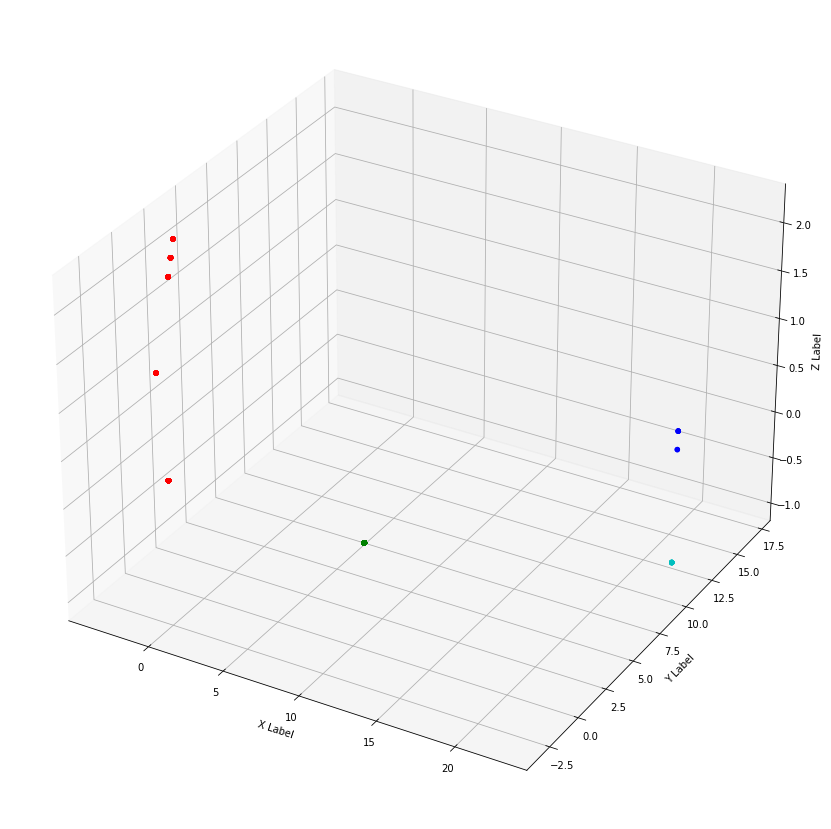

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def scatter3d(data, y_kmeans):
    clusters = len(np.unique(y_kmeans))
    colors=list("rgbcmyk")
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax = fig.add_subplot(111, projection='3d')
    for cluster in range(clusters):
        ax.scatter(data[y_kmeans==cluster, 0], data[y_kmeans==cluster, 1], data[y_kmeans==cluster, 2], c=colors[cluster%len(colors)])
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

scatter3d(reduced, y_labels)

In [11]:
df['cluster'] = y_labels
df.loc[df['cluster']==0]

,query,qtype,rcode,Answers,qlength,qparts,suffixlength,domainlength,cluster
0,vcsa.deploy.local,1,0,172.16.1.10,17,3,5,6,0
1,vcsa.deploy.local,1,0,172.16.1.10,17,3,5,6,0
2,vcsa.deploy.local,1,0,172.16.1.10,17,3,5,6,0
3,vcsa.deploy.local,1,0,172.16.1.10,17,3,5,6,0
4,vcsa.deploy.local,1,0,172.16.1.10,17,3,5,6,0
...,...,...,...,...,...,...,...,...,...
8348,vcsa.deploy.local,1,0,172.16.1.10,17,3,5,6,0
8349,vcsa.deploy.local,1,0,172.16.1.10,17,3,5,6,0
8350,vcsa.deploy.local,1,0,172.16.1.10,17,3,5,6,0
8351,vcsa.deploy.local,1,0,172.16.1.10,17,3,5,6,0


In [12]:
df.loc[df['cluster']==1]

,query,qtype,rcode,Answers,qlength,qparts,suffixlength,domainlength,cluster
23,10.1.16.172.in-addr.arpa,12,0,"photon-machine,vcsa,vcsa.deploy.local",24,6,4,7,1
29,10.1.16.172.in-addr.arpa,12,0,"photon-machine,vcsa,vcsa.deploy.local",24,6,4,7,1
33,10.1.16.172.in-addr.arpa,12,0,"photon-machine,vcsa,vcsa.deploy.local",24,6,4,7,1
34,10.1.16.172.in-addr.arpa,12,0,"photon-machine,vcsa,vcsa.deploy.local",24,6,4,7,1
37,10.1.16.172.in-addr.arpa,12,0,"photon-machine,vcsa,vcsa.deploy.local",24,6,4,7,1
...,...,...,...,...,...,...,...,...,...
8319,10.1.16.172.in-addr.arpa,12,0,"photon-machine,vcsa,vcsa.deploy.local",24,6,4,7,1
8323,10.1.16.172.in-addr.arpa,12,0,"photon-machine,vcsa,vcsa.deploy.local",24,6,4,7,1
8326,10.1.16.172.in-addr.arpa,12,0,"photon-machine,vcsa,vcsa.deploy.local",24,6,4,7,1
8329,10.1.16.172.in-addr.arpa,12,0,"photon-machine,vcsa,vcsa.deploy.local",24,6,4,7,1


In [13]:
df.loc[df['cluster']==2]

,query,qtype,rcode,Answers,qlength,qparts,suffixlength,domainlength,cluster
150,ntp.ubuntu.com,28,0,"2001:67c:1560:8003::c7,2001:67c:1560:8003::c8",14,3,3,6,2
1427,ntp.ubuntu.com,28,0,"2001:67c:1560:8003::c7,2001:67c:1560:8003::c8",14,3,3,6,2
1600,ntp.ubuntu.com,28,0,"2001:67c:1560:8003::c7,2001:67c:1560:8003::c8",14,3,3,6,2
1978,ntp.ubuntu.com,28,0,"2001:67c:1560:8003::c7,2001:67c:1560:8003::c8",14,3,3,6,2
2962,ntp.ubuntu.com,28,0,"2001:67c:1560:8003::c7,2001:67c:1560:8003::c8",14,3,3,6,2
3129,ntp.ubuntu.com,28,0,"2001:67c:1560:8003::c7,2001:67c:1560:8003::c8",14,3,3,6,2
3194,motd.ubuntu.com,28,0,"2a05:d018:91c:3200:2846:99fb:81b6:1e11,2a05:d0...",15,3,3,6,2
3573,ntp.ubuntu.com,28,0,"2001:67c:1560:8003::c7,2001:67c:1560:8003::c8",14,3,3,6,2
4567,ntp.ubuntu.com,28,0,"2001:67c:1560:8003::c7,2001:67c:1560:8003::c8",14,3,3,6,2
4718,ntp.ubuntu.com,28,0,"2001:67c:1560:8003::c7,2001:67c:1560:8003::c8",14,3,3,6,2


In [14]:
df.loc[df['cluster']==3]

,query,qtype,rcode,Answers,qlength,qparts,suffixlength,domainlength,cluster
1853,partnerweb.vmware.com,28,0,"2600:1404:d400:282::2ef,2600:1404:d400:29d::2e...",21,3,3,6,3
2066,hostupdate.vmware.com,28,0,"2600:1480:3000:cc::,eip-ntt.shd-download.vmwar...",21,3,3,6,3
2068,hostupdate.vmware.com,28,0,"2600:1480:3000:cc::,eip-ntt.shd-download.vmwar...",21,3,3,6,3
4609,partnerweb.vmware.com,28,0,"2600:1404:d400:282::2ef,2600:1404:d400:29d::2e...",21,3,3,6,3
4767,hostupdate.vmware.com,28,0,"2600:1480:3000:cc::,eip-ntt.shd-download.vmwar...",21,3,3,6,3
4768,hostupdate.vmware.com,28,0,"2600:1480:3000:cc::,eip-ntt.shd-download.vmwar...",21,3,3,6,3
7353,partnerweb.vmware.com,28,0,"2600:1404:d400:282::2ef,2600:1404:d400:29d::2e...",21,3,3,6,3
7480,hostupdate.vmware.com,28,0,"2600:1480:3000:cc::,eip-ntt.shd-download.vmwar...",21,3,3,6,3
7482,hostupdate.vmware.com,28,0,"2600:1480:3000:cc::,eip-ntt.shd-download.vmwar...",21,3,3,6,3


In [15]:
df.loc[df['cluster']==4]

,query,qtype,rcode,Answers,qlength,qparts,suffixlength,domainlength,cluster
